# Merging Climate Datasets Exercise

Work through this notebook to practice harmonizing and merging two climate datasets that differ in temporal cadence and spatial resolution.

You will: 
- Load two public NOAA datasets directly from the cloud
- Subset to the continental US (use 230°E–300°E in longitude since the data span 0–360°)
- Use `xr.resample` to aggregate time and `xr.interp` to match grids
- Combine the variables with `xr.merge` for joint analysis

Refer back to the answer key after attempting each step.


## 1. Setup


In [1]:
import matplotlib.pyplot as plt
import xarray as xr

try:
    import cartopy.crs as ccrs
    import cartopy.feature as cfeature
except ImportError:
    ccrs = None
    cfeature = None

TEMP_URL = "https://psl.noaa.gov/thredds/dodsC/Datasets/ncep.reanalysis/surface/air.sig995.2020.nc"
PRECIP_URL = "https://psl.noaa.gov/thredds/dodsC/Datasets/cpc_global_precip/precip.2020.nc"

LAT_RANGE = (20, 50)  # degrees North
LON_RANGE_360 = (230, 300)  # degrees East (equivalent to -130° to -60°)
LON_RANGE_180 = (-130, -60)  # convenience if a dataset uses -180° to 180°

TIME_RANGE = slice("2020-06-01", "2020-06-30")


## 2. Load the datasets

Open both remote datasets with `xr.open_dataset`, passing a reasonable chunk size for the time dimension. Assign the resulting objects to `air` and `precip`.


In [2]:
# TODO: load the air temperature and precipitation datasets.
# Example: air = xr.open_dataset(..., chunks={"time": 8})
#raise NotImplementedError("Assign datasets to `air` and `precip`.")

air = xr.open_dataset(TEMP_URL, chunks={'time':10})
precip = xr.open_dataset(PRECIP_URL, chunks={'time':10})


## 3. Subset to the continental United States and June 2020

Select the bounding box provided above and limit the time range to June 2020 for both datasets. Store the results in `air_us` and `precip_us`.
Remember that longitude runs from 0° to 360°, so select 230°E–300°E. Check whether each coordinate is ascending or descending before building the slice.


In [3]:
# TODO: subset both datasets using `sel`, handling coordinate ordering as needed.
#raise NotImplementedError("Create `air_us` and `precip_us`.")
lons_us = [-67+360, -125+360]
lats_us = [25, 50]

air_us = air.sel(lat=slice(lats_us[1], lats_us[0]), lon=slice(lons_us[1], lons_us[0]), time=TIME_RANGE)

air_us

<xarray.Dataset> Size: 128kB
Dimensions:  (time: 120, lat: 11, lon: 24)
Coordinates:
  * lat      (lat) float32 44B 50.0 47.5 45.0 42.5 40.0 ... 32.5 30.0 27.5 25.0
  * lon      (lon) float32 96B 235.0 237.5 240.0 242.5 ... 287.5 290.0 292.5
  * time     (time) datetime64[ns] 960B 2020-06-01 ... 2020-06-30T18:00:00
Data variables:
    air      (time, lat, lon) float32 127kB dask.array<chunksize=(2, 11, 24), meta=np.ndarray>
Attributes:
    Conventions:                     COARDS
    title:                           4x daily NMC reanalysis (2014)
    history:                         created 2017/12 by Hoop (netCDF2.3)
    description:                     Data is from NMC initialized reanalysis\...
    platform:                        Model
    dataset_title:                   NCEP-NCAR Reanalysis 1
    _NCProperties:                   version=2,netcdf=4.6.3,hdf5=1.10.5
    References:                      http://www.psl.noaa.gov/data/gridded/dat...
    DODS_EXTRA.Unlimited_Dimension:  time

In [4]:
precip_us = precip.sel(lat=slice(lats_us[1], lats_us[0]), lon=slice(lons_us[1], lons_us[0]), time=TIME_RANGE)

precip_us

<xarray.Dataset> Size: 697kB
Dimensions:  (time: 30, lat: 50, lon: 116)
Coordinates:
  * lat      (lat) float32 200B 49.75 49.25 48.75 48.25 ... 26.25 25.75 25.25
  * lon      (lon) float32 464B 235.2 235.8 236.2 236.8 ... 291.8 292.2 292.8
  * time     (time) datetime64[ns] 240B 2020-06-01 2020-06-02 ... 2020-06-30
Data variables:
    precip   (time, lat, lon) float32 696kB dask.array<chunksize=(8, 50, 116), meta=np.ndarray>
Attributes:
    _NCProperties:                   version=1|netcdflibversion=4.4.1.1|hdf5l...
    Conventions:                     CF-1.0
    version:                         V1.0
    title:                           CPC GLOBAL PRCP V1.0 RT
    dataset_title:                   CPC GLOBAL PRCP V1.0
    Source:                          ftp://ftp.cpc.ncep.noaa.gov/precip/CPC_U...
    References:                      https://www.psl.noaa.gov/data/gridded/da...
    history:                         Updated 2021-01-02 23:31:03
    DODS_EXTRA.Unlimited_Dimension:  time

## 4. Align temporal cadence

Aggregate the six-hourly air temperatures to daily means with `xr.resample`. Name the resulting DataArray `air_daily`.


In [5]:
# TODO: use xr.resample to create daily means.
#raise NotImplementedError("Create `air_daily`.")

air_daily = air_us.resample(time='1D').mean()

air_daily

<xarray.Dataset> Size: 32kB
Dimensions:  (time: 30, lat: 11, lon: 24)
Coordinates:
  * lat      (lat) float32 44B 50.0 47.5 45.0 42.5 40.0 ... 32.5 30.0 27.5 25.0
  * lon      (lon) float32 96B 235.0 237.5 240.0 242.5 ... 287.5 290.0 292.5
  * time     (time) datetime64[ns] 240B 2020-06-01 2020-06-02 ... 2020-06-30
Data variables:
    air      (time, lat, lon) float32 32kB dask.array<chunksize=(1, 11, 24), meta=np.ndarray>
Attributes:
    Conventions:                     COARDS
    title:                           4x daily NMC reanalysis (2014)
    history:                         created 2017/12 by Hoop (netCDF2.3)
    description:                     Data is from NMC initialized reanalysis\...
    platform:                        Model
    dataset_title:                   NCEP-NCAR Reanalysis 1
    _NCProperties:                   version=2,netcdf=4.6.3,hdf5=1.10.5
    References:                      http://www.psl.noaa.gov/data/gridded/dat...
    DODS_EXTRA.Unlimited_Dimension:  time

## 5. Interpolate to the precipitation grid

Use `xr.interp` to interpolate the daily air temperatures onto the precipitation grid (`precip_us.lat` and `precip_us.lon`). Store the interpolated result in `air_interp`.


In [6]:
# TODO: interpolate the resampled temperature field onto the precipitation grid.
#raise NotImplementedError("Create `air_interp`.")

air_interp = air_us.interp(
    lat=precip_us.lat,
    lon=precip_us.lon
 )

air_interp

<xarray.Dataset> Size: 3MB
Dimensions:  (time: 120, lat: 50, lon: 116)
Coordinates:
  * time     (time) datetime64[ns] 960B 2020-06-01 ... 2020-06-30T18:00:00
  * lat      (lat) float32 200B 49.75 49.25 48.75 48.25 ... 26.25 25.75 25.25
  * lon      (lon) float32 464B 235.2 235.8 236.2 236.8 ... 291.8 292.2 292.8
Data variables:
    air      (time, lat, lon) float32 3MB dask.array<chunksize=(2, 50, 116), meta=np.ndarray>
Attributes:
    Conventions:                     COARDS
    title:                           4x daily NMC reanalysis (2014)
    history:                         created 2017/12 by Hoop (netCDF2.3)
    description:                     Data is from NMC initialized reanalysis\...
    platform:                        Model
    dataset_title:                   NCEP-NCAR Reanalysis 1
    _NCProperties:                   version=2,netcdf=4.6.3,hdf5=1.10.5
    References:                      http://www.psl.noaa.gov/data/gridded/dat...
    DODS_EXTRA.Unlimited_Dimension:  time

## 6. Merge the datasets

Convert the aligned arrays into datasets with clear variable names and merge them with `xr.merge`. Save the output as `merged`.


In [7]:
# TODO: build datasets and merge them into one object named `merged`.
#raise NotImplementedError("Create `merged`.")

merged = xr.merge([air_interp, precip_us])


/tmp/ipykernel_23194/1384307522.py:4: FutureWarning: In a future version of xarray the default value for join will change from join='outer' to join='exact'. This change will result in the following ValueError: cannot be aligned with join='exact' because index/labels/sizes are not equal along these coordinates (dimensions): 'time' ('time',) The recommendation is to set join explicitly for this case.
  merged = xr.merge([air_interp, precip_us])


## 7. Inspect your result

Once your pipeline runs without `NotImplementedError`, evaluate the following cell to sanity-check the merged dataset.


In [8]:
# The assertions below should pass once you have completed the exercise.
#assert set(merged.data_vars) == {"air_temperature", "daily_precip"}
#assert merged.air_temperature.dims == merged.daily_precip.dims
print(merged)


<xarray.Dataset> Size: 6MB
Dimensions:  (time: 120, lat: 50, lon: 116)
Coordinates:
  * time     (time) datetime64[ns] 960B 2020-06-01 ... 2020-06-30T18:00:00
  * lat      (lat) float32 200B 49.75 49.25 48.75 48.25 ... 26.25 25.75 25.25
  * lon      (lon) float32 464B 235.2 235.8 236.2 236.8 ... 291.8 292.2 292.8
Data variables:
    air      (time, lat, lon) float32 3MB dask.array<chunksize=(2, 50, 116), meta=np.ndarray>
    precip   (time, lat, lon) float32 3MB dask.array<chunksize=(7, 50, 116), meta=np.ndarray>
Attributes:
    Conventions:                     COARDS
    title:                           4x daily NMC reanalysis (2014)
    history:                         created 2017/12 by Hoop (netCDF2.3)
    description:                     Data is from NMC initialized reanalysis\...
    platform:                        Model
    dataset_title:                   NCEP-NCAR Reanalysis 1
    _NCProperties:                   version=2,netcdf=4.6.3,hdf5=1.10.5
    References:             

In [9]:
merged

<xarray.Dataset> Size: 6MB
Dimensions:  (time: 120, lat: 50, lon: 116)
Coordinates:
  * time     (time) datetime64[ns] 960B 2020-06-01 ... 2020-06-30T18:00:00
  * lat      (lat) float32 200B 49.75 49.25 48.75 48.25 ... 26.25 25.75 25.25
  * lon      (lon) float32 464B 235.2 235.8 236.2 236.8 ... 291.8 292.2 292.8
Data variables:
    air      (time, lat, lon) float32 3MB dask.array<chunksize=(2, 50, 116), meta=np.ndarray>
    precip   (time, lat, lon) float32 3MB dask.array<chunksize=(7, 50, 116), meta=np.ndarray>
Attributes:
    Conventions:                     COARDS
    title:                           4x daily NMC reanalysis (2014)
    history:                         created 2017/12 by Hoop (netCDF2.3)
    description:                     Data is from NMC initialized reanalysis\...
    platform:                        Model
    dataset_title:                   NCEP-NCAR Reanalysis 1
    _NCProperties:                   version=2,netcdf=4.6.3,hdf5=1.10.5
    References:                      http://www.psl.noaa.gov/data/gridded/dat...
    DODS_EXTRA.Unlimited_Dimension:  time

## 8. Check In

- Render both variables at the first timestep on a `cartopy` map to verify alignment visually (PlateCarree works well).
- Build a scatter plot comparing colocated temperature and precipitation values across the merged domain.
- Save the merged output with `to_netcdf` for future analysis.


Text(0.5, 1.0, 'United States Air Temperature and Precipitation, 06-01,2020')

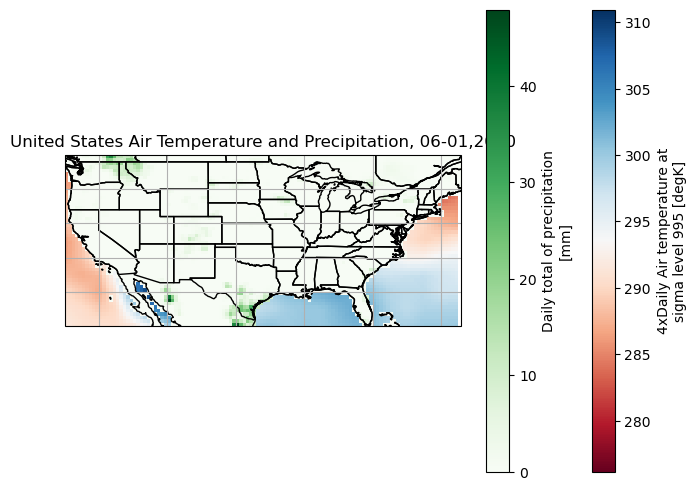

In [10]:
fig, ax = plt.subplots(
    figsize=(8,6),
    subplot_kw={'projection': ccrs.PlateCarree()}
)

ax.coastlines()
ax.add_feature(cfeature.STATES)
ax.gridlines()

air_plot = merged['air'].isel(time=0).plot(
    ax=ax,
    transform=ccrs.PlateCarree(),
    cmap='RdBu',
    add_colorbar=True
)

precip_plot = merged['precip'].isel(time=0).plot(
    ax=ax,
    transform=ccrs.PlateCarree(),
    cmap='Greens',
    add_colorbar=True
)

ax.set_title('United States Air Temperature and Precipitation, 06-01,2020')




Text(0.5, 1.0, 'Temperature vs Precipitation, 06-01-2020')

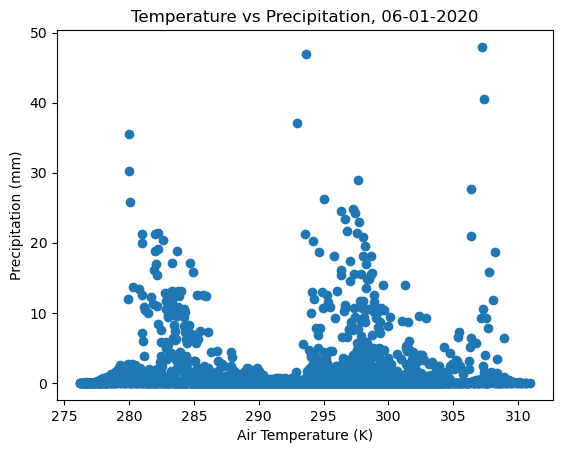

In [11]:
plt.scatter(merged['air'].isel(time=0), merged['precip'].isel(time=0))
plt.xlabel('Air Temperature (K)')
plt.ylabel('Precipitation (mm)')
plt.title('Temperature vs Precipitation, 06-01-2020')

In [12]:
merged.to_netcdf('US_precip_air_062020.nc')

AttributeError: NetCDF: String match to name in use